In [1]:
import sys; sys.path.append('../../wwa/'); from wwa import *

xn, xx, yn, yx = [-18,52,0,35]

mapproj = cartopy.crs.PlateCarree()

fpath = "../../00_WWA_project_folder/ephemeral/00_Sahel-heat/"

# Sahel heatwave

- ERA5 tmax & tmin downloaded - extended version not yet available - also unclear whether we can trust - but we can talk about trends based on the data that is available
- MSWX tmax & tmin already include the event
- CMIP6 tmax & tmin currently downloading from Synda
- CMIP6 tx1x downloaded from Copernicus
- check seasonal cycle: do we need to split the region out at all?  
&nbsp;
- fit gridded model across Sahel region: local return periods as well as regional (although can we rely on ERA5 analysis for this?)

---
# Get data

## ERA5

In [1]:
# Download ERA5 data from climate explorer
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://climexp.knmi.nl/data/era5_tmax_daily_af_extended_-18-52E_0-35N_su.nc
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://climexp.knmi.nl/data/era5_tmin_daily_af_extended_-18-52E_0-35N_su.nc

## MSWX

In [2]:
mswx_path = "../../00_WWA_project_folder/live/data/mswx/"
out_path = "../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"

In [ ]:
varnm = "tmin"
for y in range(2024,1978,-1):
    
    new_fnm = out_path+varnm+"_mam_"+str(y)+".nc"
    
    if os.path.exists(new_fnm): continue
        
    fl = [fnm for fnm in sorted(glob.glob(mswx_path+varnm+"_*/"+str(y)+"*.nc")) if int(fnm[-6:-3]) >= 59 and int(fnm[-6:-3]) <= 152]
    da = wrap_lon(xr.open_mfdataset(fl)).air_temperature.sel(lon = slice(xn,xx), lat = slice(yn,yx), time = slice(str(y)+"-03", str(y)+"-05")).rename(varnm)
    da.to_netcdf(new_fnm)

## CMIP6 from Copernicus (monthly tx1x)

In [1]:
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.esgf_wps.retrieve-1712653060.156834-22281-9-9becd21d-53a0-45ce-b2f5-de4b043b7920.zip
! cd /rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/00_Sahel-heat; wget https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data1/adaptor.esgf_wps.retrieve-1712654454.3825753-14305-12-37345cc8-d2fa-487d-bc7c-e44d557242ac.zip

/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: scl: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `scl'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
--2024-04-09 10:20:26--  https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data3/adaptor.esgf_wps.retrieve-1712653060.156834-22281-9-9becd21d-53a0-45ce-b2f5-de4b043b7920.zip
Resolving download-0000-clone.copernicus-climate.eu (download-0000-clone.copernicus-climate.eu)... 2a0c:5bc0:4c:ff::889c:9821, 136.156.152.33
Connecting to download-0000-clone.copernicus-climate.eu (download-0000-clone.copernicus-climate.eu)|2a0c:5bc0:4c:ff::889c:9821|:443... connected.
HTTP request sent, awaiting respo

# Physical geography

In [42]:
elev = wrap_lon(xr.open_dataset("../../00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False)).squeeze(drop = True).data

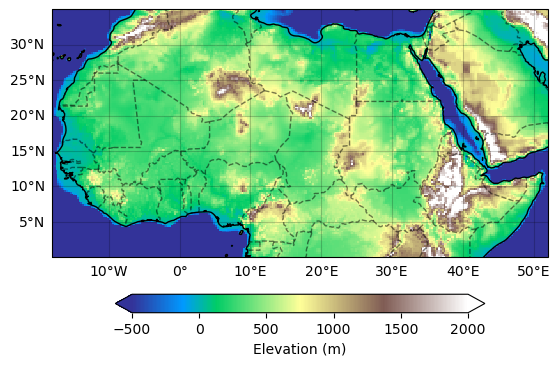

In [55]:
elev.sel(lon = slice(xn,xx), lat = slice(yn,yx)).plot(cmap = "terrain", vmax = 2000, vmin = -500, subplot_kws = {"projection" : mapproj}, 
                                                      cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.1, "label" : "Elevation (m)"})
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.gridlines(color = "k", alpha = 0.2, draw_labels = ["left", "bottom"])

plt.savefig("fig/elevation.png")

# Seasonal cycle per lat/lon

In [58]:
# seasonal cycle at each latitude - use daily data for this
tmax = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/era5_tmax_daily_af_extended_-18-52E_0-35N_su.nc").tmax
tmax = tmax.sel(time = slice("1980", "2020"))

In [62]:
sc_by_lat = tmax.groupby_bins(group = "lat", bins = range(yn,yx+1)).mean().mean("lon").groupby("time.dayofyear").mean()
sc_by_lon = tmax.groupby_bins(group = "lon", bins = range(xn,xx+1)).mean().mean("lat").groupby("time.dayofyear").mean()

NameError: name 'sc_by_lat' is not defined

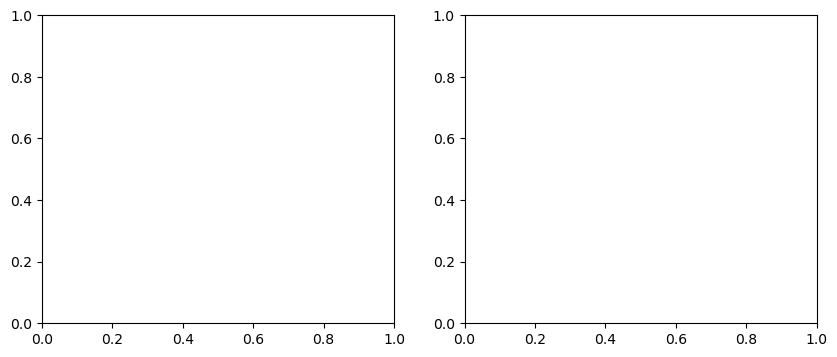

In [16]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)

sc_by_lat.transpose().plot(ax = axs[0], cmap = "YlOrRd", add_colorbar = False) 
axs[0].set_ylabel("Latitude")
axs[0].axhline(16, color = "darkblue", ls = "--")

[axs[0].axvline(x, color = "k", alpha = 0.5, ls = "--") for x in [91]]

sc_by_lon.plot(ax = axs[1], cmap = "YlOrRd", add_colorbar = False) 
axs[1].set_xlabel("Longitude")
[axs[1].axhline(x, color = "k", alpha = 0.5, ls = "--") for x in [91]]

plt.suptitle("Seasonal cycle at each latitude & longitude (ERA5, 1980-2020)")
plt.savefig("fig/tmax_seasonal-cycle_latlon_era5.png")

# 2024 anomalies

In [8]:
sites = pd.DataFrame.from_dict({k : get_latlon(k) for k in ["Bamako, Mali", "Timbuktu, Mali"]}).transpose()

varnm = "tmin"

temp_range = {"tmax" : {"vmin" : 0, "vmax" : 45}, "tmin" : {"vmin" : 0, "vmax" : 30}}
anom_range = {"tmax" : {"vmin" : -10, "vmax" : 10}, "tmin" : {"vmin" : -10, "vmax" : 10}}

In [9]:
# load tmax climatology
fl = [fnm for fnm in sorted(glob.glob(fpath+"mswx/"+varnm+"_mam_*.nc")) if int(fnm[-7:-3]) >= 1990 and int(fnm[-7:-3]) <= 2020][1:]
clim_apr = xr.open_mfdataset(fl)[varnm].groupby("time.month")[4].mean("time")

# load 2024 tmax
da = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"+varnm+"_mam_2024.nc")[varnm]
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat)
da = da.where(rm.sum("region") == 1)

# 2024 anomaly wrt April climatology
anom_apr = da - clim_apr

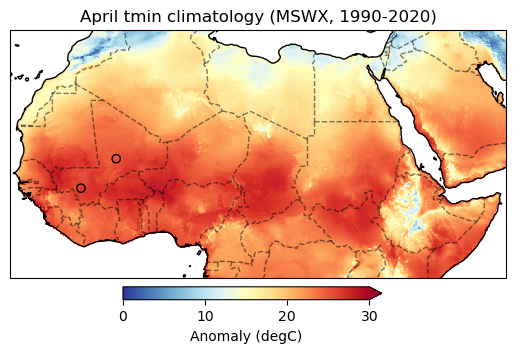

In [10]:
clim_apr.where(rm.sum("region") == 1).plot(**temp_range[varnm], cmap =  "RdYlBu_r", subplot_kws = {"projection" : mapproj},
                                                       cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Anomaly (degC)"})

for ax in plt.gcf().axes[:1]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    
ax.set_title("April "+varnm + " climatology (MSWX, 1990-2020)")
plt.savefig("fig/April-climatology-"+varnm+".png")

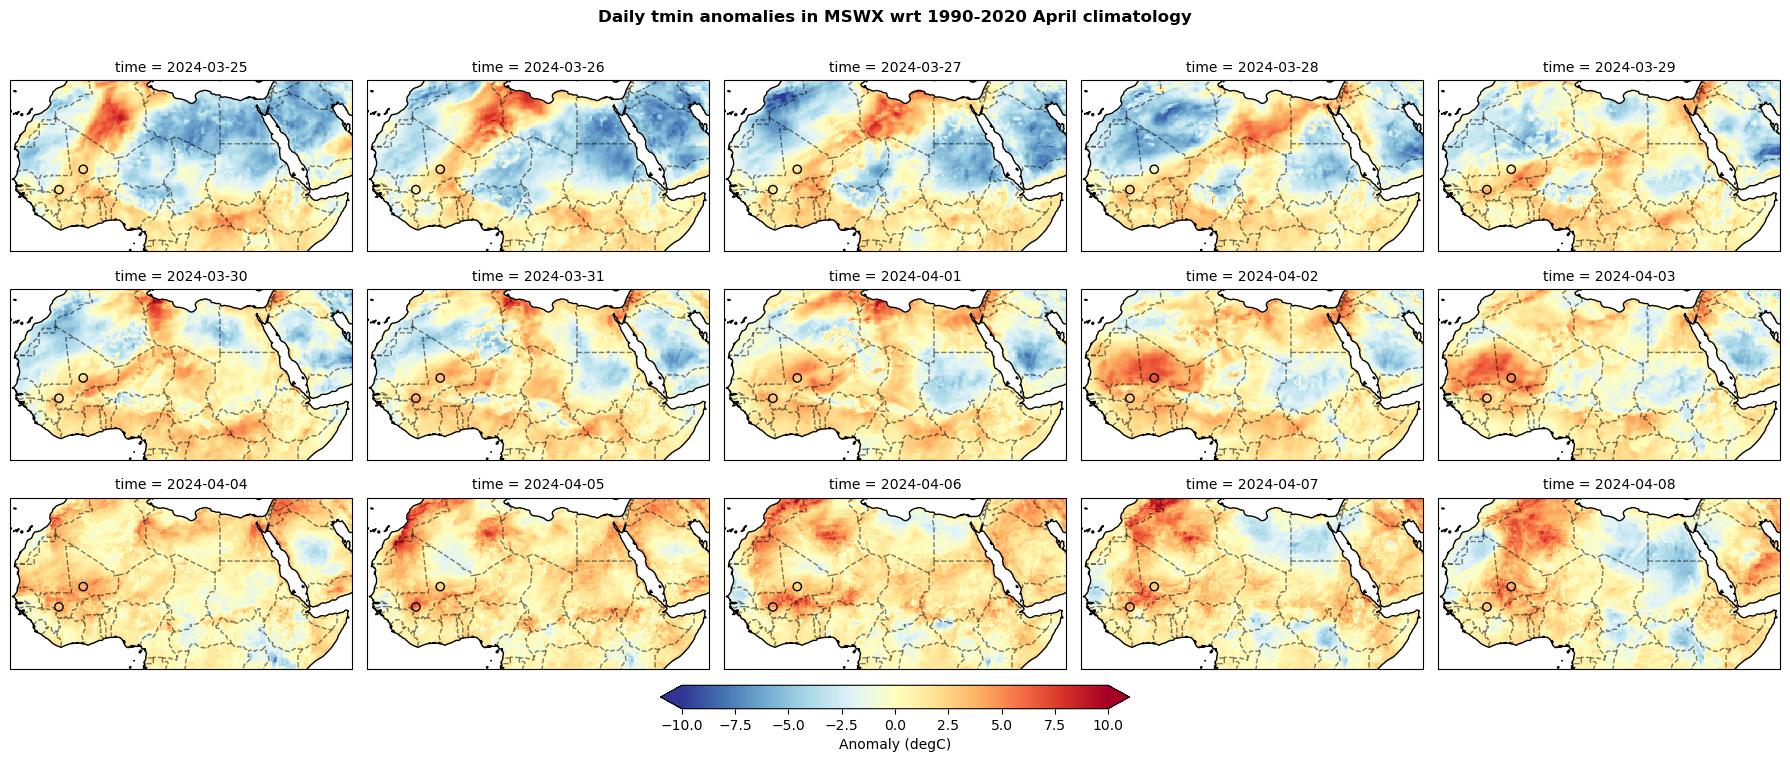

In [11]:
anom_apr.isel(time = slice(-15, None)).plot(col = "time", col_wrap = 5, figsize = (18,7), **anom_range[varnm], cmap =  "RdYlBu_r", subplot_kws = {"projection" : mapproj},
                                                      cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Anomaly (degC)"})

for ax in plt.gcf().axes[:15]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    
plt.suptitle("Daily "+varnm+" anomalies in MSWX wrt 1990-2020 April climatology", fontweight = "bold", y = 1.02)
    
plt.savefig("fig/daily-"+varnm+"-anomalies.png")

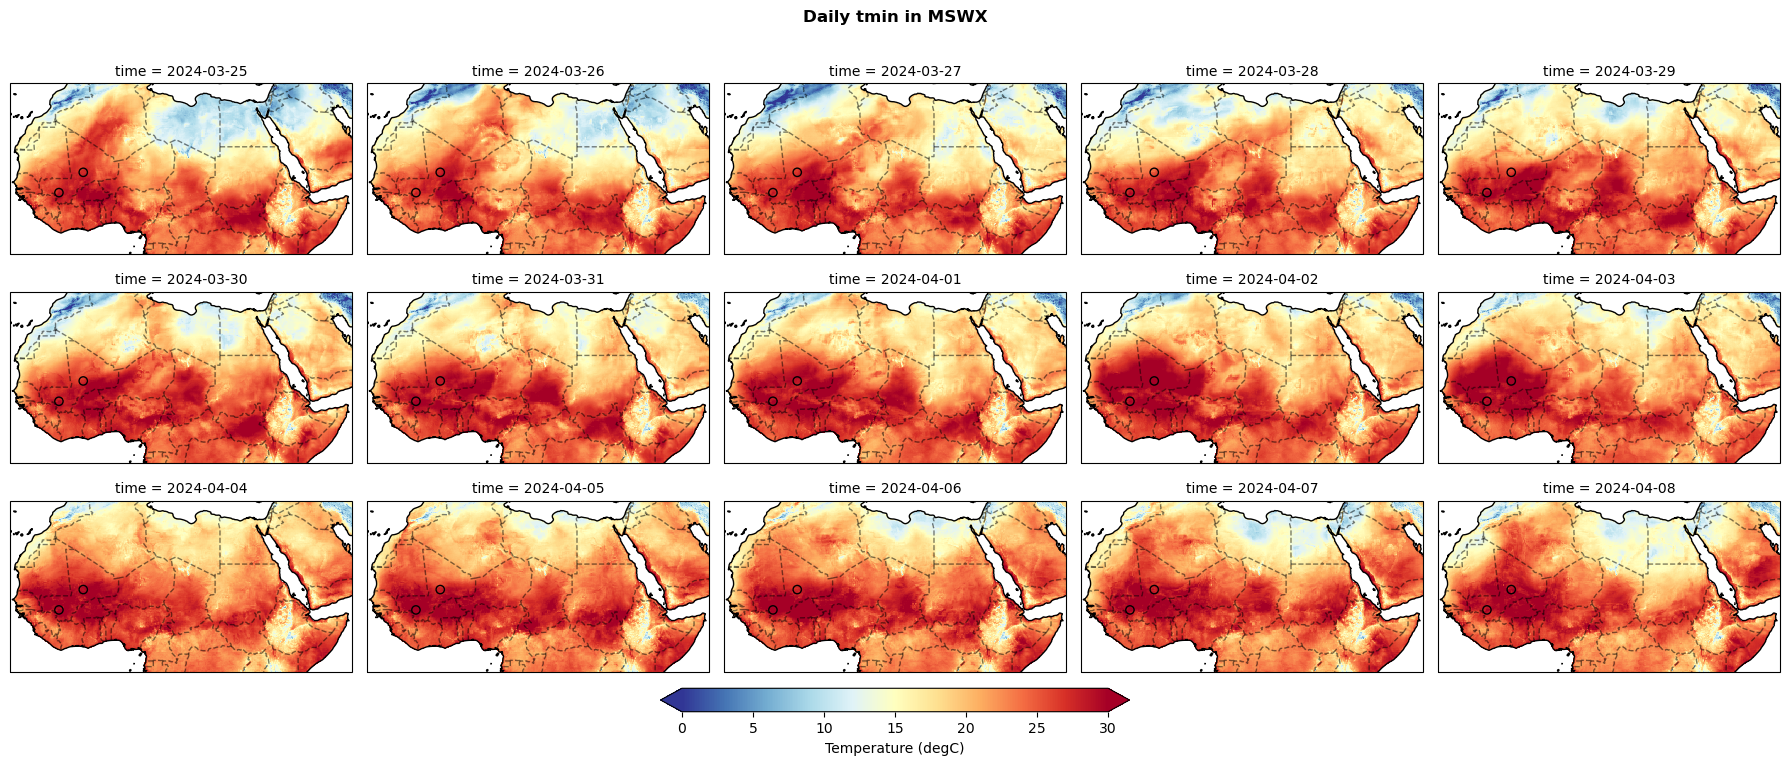

In [12]:
da.isel(time = slice(-15, None)).plot(col = "time", col_wrap = 5, cmap = "RdYlBu_r", **temp_range[varnm], figsize = (18,7), subplot_kws = {"projection" : mapproj},
                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Temperature (degC)"})

for ax in plt.gcf().axes[:15]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    
plt.suptitle("Daily "+varnm+" in MSWX", fontweight = "bold", y = 1.025)

plt.savefig("fig/daily-"+varnm+".png")

# Maps of n-day accumulations

In [42]:
varnm = "tmin"
da = xr.open_dataset("../../00_WWA_project_folder/ephemeral/00_Sahel-heat/mswx/"+varnm+"_mam_2024.nc")[varnm]
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat)
da = da.where(rm.sum("region") == 1)

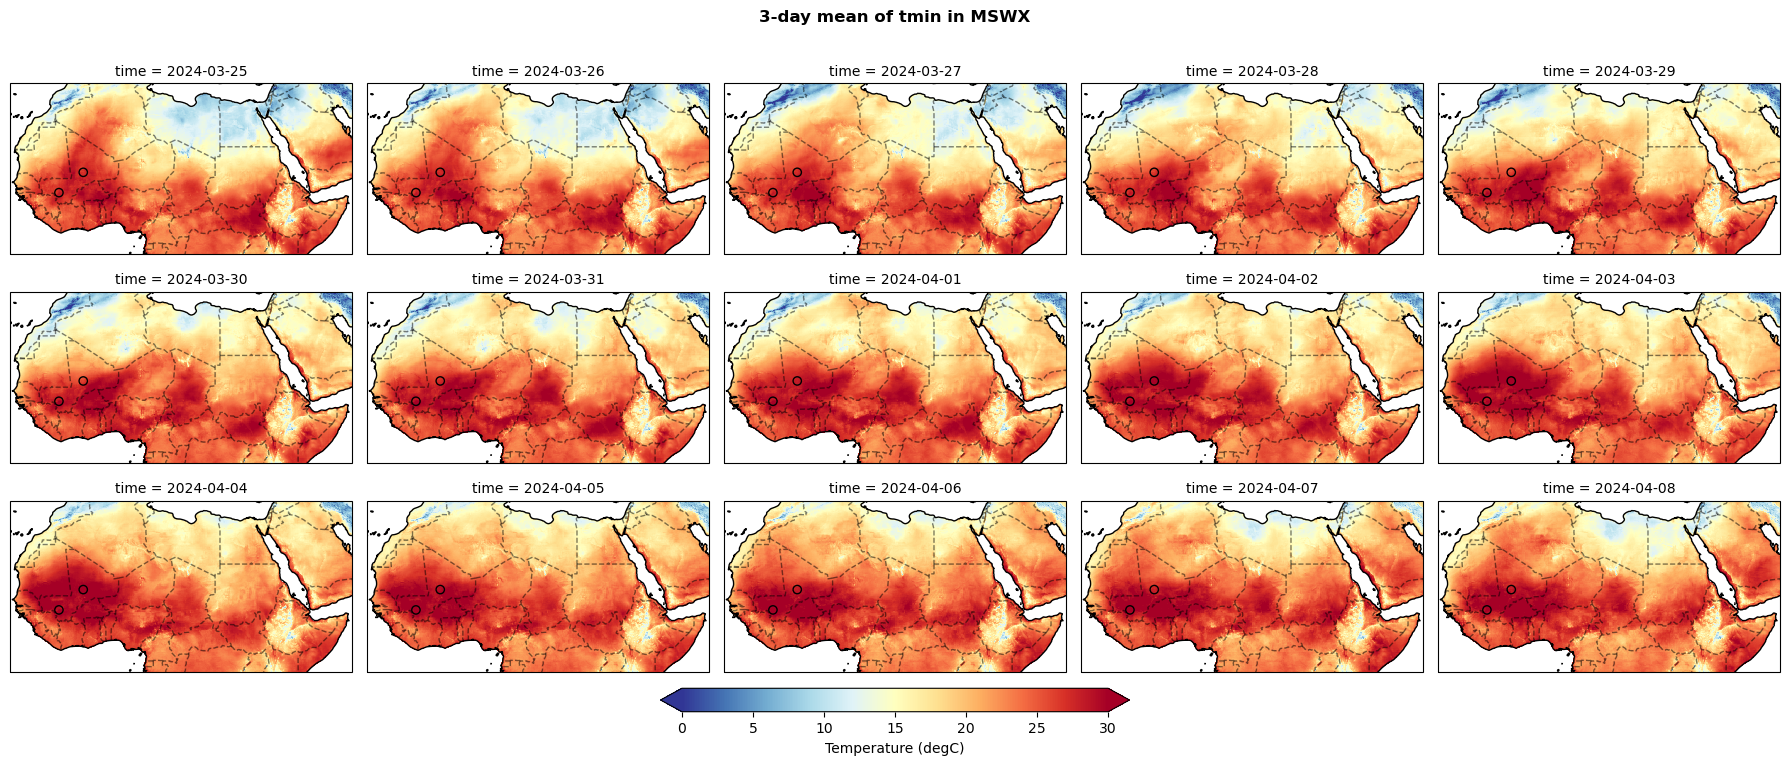

In [44]:
ndays = 3

da.rolling(time = ndays).mean().isel(time = slice(-15, None)).plot(col = "time", col_wrap = 5, cmap = "RdYlBu_r", **temp_range[varnm], figsize = (18,7), subplot_kws = {"projection" : mapproj},
                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.035, "pad" : 0.025, "label" : "Temperature (degC)"})

for ax in plt.gcf().axes[:15]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.scatter(sites.lon, sites.lat, marker = "o", edgecolors = "k", facecolors = "none")
    
plt.suptitle(str(ndays)+"-day mean of "+varnm+" in MSWX", fontweight = "bold", y = 1.025)

plt.savefig("fig/"+str(ndays)+"-day-"+varnm+"_mswx.png")

# Mali-Burkina Faso time series

In [50]:
# map to select country regions ( chad 15; niger 55; mauritania 53; burkina faso 65; mali 52)
# rm.plot(col = "region", col_wrap = 7, subplot_kws = {"projection" : mapproj, "extent" : [xn,xx,yn,yx]})
# for ax in plt.gcf().axes[:-1]:
#     ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.6, ls = "--")

In [13]:
# extract time series
varnm = "tmax"

fl = sorted(glob.glob(fpath+"mswx/"+varnm+"_*.nc"))
da = xr.open_mfdataset(fl)[varnm]
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat)

malibf = da.where(rm.sel(region = [52,65], lat = slice(None, 16)).sum("region") == 1).mean(["lat", "lon"])
malibf.to_netcdf(varnm+"_mswx_mali-burkinafaso.nc")

## Compare timescales

In [14]:
tmax = xr.open_dataset("tmax_mswx_mali-burkinafaso.nc").tmax
tmin = xr.open_dataset("tmin_mswx_mali-burkinafaso.nc").tmin

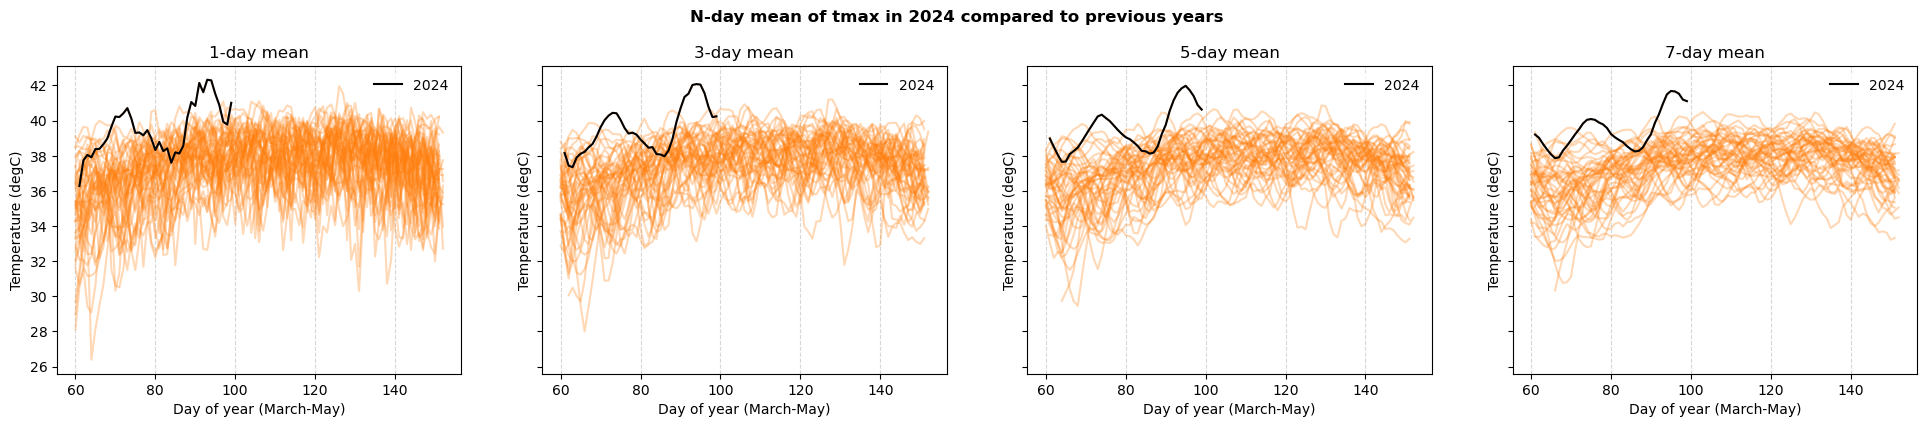

In [15]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (6*4,4*1), dpi = 100, sharey = True)

for i in range(4):
    
    ndays = [1,3,5,7,9,15][i]
    ax = plt.gcf().axes[i]
    ts = tmax.rolling(time = ndays, center = False).mean()

    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:orange", alpha = 0.3)
    ax.plot(ts.sel(time = "2024").time.dt.dayofyear, ts.sel(time = "2024"), color = "k", label = "2024")
    ax.legend(edgecolor = "w")
    ax.set_xlabel("Day of year (March-May)")
    ax.set_ylabel("Temperature (degC)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    
    ax.set_title(str(ndays)+"-day mean")
        
    fig.suptitle("N-day mean of tmax in 2024 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig("fig/n-day-mean-of-tmax.png")

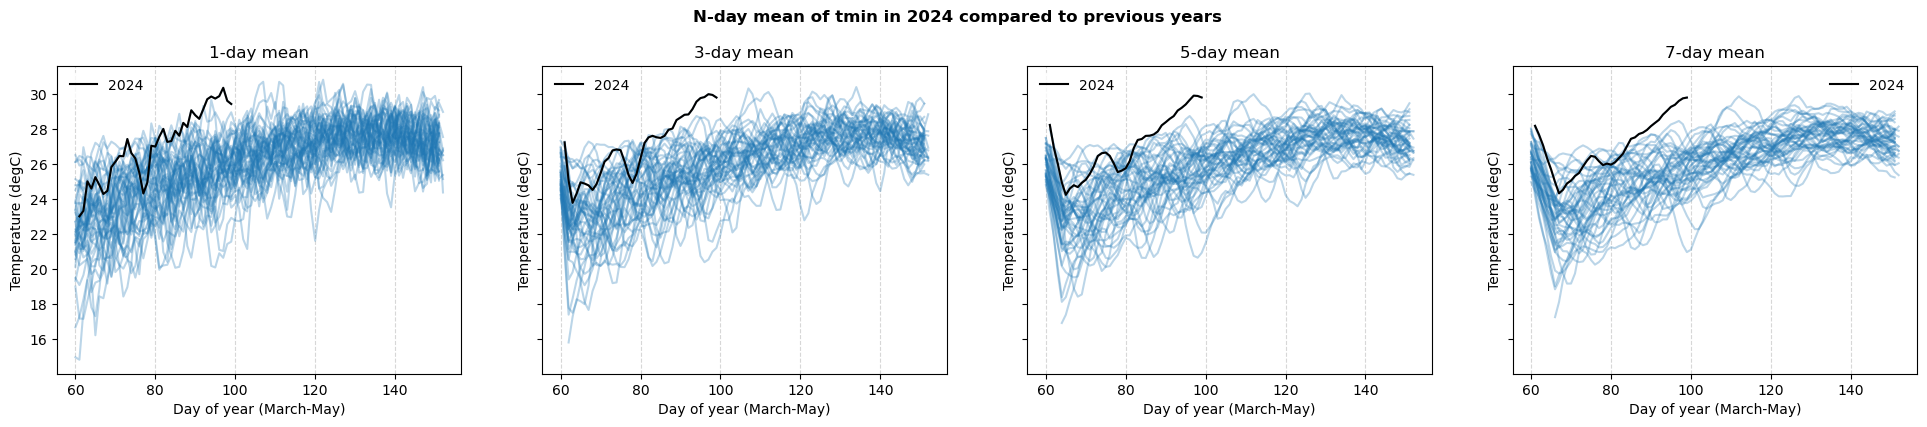

In [16]:
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (6*4,4*1), dpi = 100, sharey = True)

for i in range(4):
    
    ndays = [1,3,5,7,9,15][i]
    ax = plt.gcf().axes[i]
    ts = tmin.rolling(time = ndays, center = False).mean()

    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
    ax.plot(ts.sel(time = "2024").time.dt.dayofyear, ts.sel(time = "2024"), color = "k", label = "2024")
    ax.legend(edgecolor = "w")
    ax.set_xlabel("Day of year (March-May)")
    ax.set_ylabel("Temperature (degC)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
    
    ax.set_title(str(ndays)+"-day mean")
        
    fig.suptitle("N-day mean of tmin in 2024 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig("fig/n-day-mean-of-tmin.png")

## Time series for climate explorer

In [31]:
# MAM maxima
for varnm in ["tmax", "tmin"]:
    for ndays in [3,5]:

        ts = xr.open_dataset(varnm+"_mswx_mali-burkinafaso.nc")[varnm].rolling(time = ndays).mean().resample(time = "AS-JAN").max()
        ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
        
        csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-mam_mali-bf_mswx"
        csv_fullpath = "ts/"+csv_fnm+".dat"
        
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: MSWX spring maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
        str2 = "# "+varnm+" [degC] March-May maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures in southern Mali & Burkina Faso at "+csv_fnm+".dat"
        head = "# year "+varnm
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
        clear_output(wait = False)

In [69]:
# April maxima
for varnm in ["tmax", "tmin"]:
    for ndays in [3,5]:

        ts = xr.open_dataset(varnm+"_mswx_mali-burkinafaso.nc")[varnm].rolling(time = ndays).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
        ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
        
        csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-april_mali-bf_mswx"
        csv_fullpath = "ts/"+csv_fnm+".dat"
        
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: MSWX April maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
        str2 = "# "+varnm+" [degC] April maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures in southern Mali & Burkina Faso at "+csv_fnm+".dat"
        head = "# year "+varnm
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
        clear_output(wait = False)

# W Africa inland time series

In [65]:
# extract time series
varnm = "tmin"

Xn,Xx,Yn,Yx = [-10,20,10,17]

box_str = "_".join([str(i) for i in [Xn,Xx,Yn,Yx]])
fl = sorted(glob.glob(fpath+"mswx/"+varnm+"_*.nc"))
da = xr.open_mfdataset(fl)[varnm]

In [63]:
da.sel(lon = slice(Xn,Xx), lat = slice(Yn,Yx)).mean(["lon", "lat"]).to_netcdf(varnm+"_mswx_"+box_str+".nc")

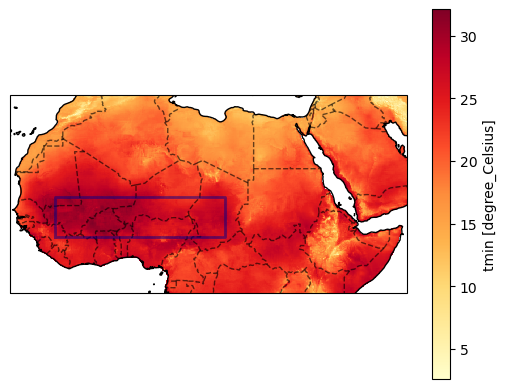

In [64]:
da.sel(time = "2024-04").mean("time").where(rm.sum("region") == 1).plot(cmap = "YlOrRd", subplot_kws = {"projection" : mapproj})

ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.6, ls = "--")

ax.plot([Xn,Xn,Xx,Xx,Xn], [Yn,Yx,Yx,Yn,Yn], color = "darkblue", lw = 2, alpha = 0.5)

## Time series for climate explorer

In [67]:
# MAM maxima
for varnm in ["tmax", "tmin"]:
    for ndays in [3,5]:

        ts = xr.open_dataset(varnm+"_mswx_"+box_str+".nc")[varnm].rolling(time = ndays).mean().resample(time = "AS-JAN").max()
        ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
        
        csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-mam_"+box_str+"_mswx"
        csv_fullpath = "ts/"+csv_fnm+".dat"
        
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: MSWX spring maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
        str2 = "# "+varnm+" [degC] March-May maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures across West Africa region at "+csv_fnm+".dat"
        head = "# year "+varnm
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
        clear_output(wait = False)

In [70]:
# April maxima
for varnm in ["tmax", "tmin"]:
    for ndays in [3,5]:

        ts = xr.open_dataset(varnm+"_mswx_"+box_str+".nc")[varnm].rolling(time = ndays).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
        ts = ts.assign_coords(time = ts.time.dt.year).rename(time = "year").to_dataframe()
        
        csv_fnm = "sahel-heat_"+varnm[0]+varnm[3]+str(ndays)+"x-april_"+box_str+"_mswx"
        csv_fullpath = "ts/"+csv_fnm+".dat"
        
        if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

        # create extra header lines for upload to Climate Explorer 
        str1 = "# contact :: MSWX April maxima of "+str(ndays)+"-day "+varnm+" - Sahel heat 2024, c.barnes22@imperial.ac.uk"
        str2 = "# "+varnm+" [degC] April maximum of "+str(ndays)+"-day "+varnm[1:]+"imum temperatures across West Africa region at "+csv_fnm+".dat"
        head = "# year "+varnm
        
        # make .dat file
        ! echo "$str1 " > $csv_fullpath
        ! echo "$str2" >> $csv_fullpath
        ! echo "$head" >> $csv_fullpath
        ts.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
        
        clear_output(wait = False)